In [2]:
!pip install optuna 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier  # Changed from GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import optuna

# Load the dataset
full_data = pd.read_parquet("full_dataset.parquet.gzip")

# Split the dataset into training and testing sets
random.seed(51)
testing_categories = [1, 2, 3, 4, 5, 6]
random.shuffle(testing_categories)

testing_set = [f"{platform}{number}" for platform, number in zip(full_data["SM_platform"].unique(), testing_categories)]
testing_df = full_data[full_data["source_name"].isin(testing_set)]
training_df = full_data[~full_data["source_name"].isin(testing_set)]

# Only select standardized columns
columns_to_select = [col for col in full_data.columns if 'zscore' in col] + ["SM_platform", "index"] + [col for col in
                                                                                                        full_data.columns
                                                                                                        if 'pc' in col]
training_df = training_df.loc[:, columns_to_select]
testing_df = testing_df.loc[:, columns_to_select]

# Separate features and target
X_train = training_df.drop(columns=["SM_platform"])
y_train = training_df["SM_platform"]
X_test = testing_df.drop(columns=["SM_platform"])
y_test = testing_df["SM_platform"]

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Optuna objective function for hyperparameter tuning
def objective(trial):
    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 30),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    }

    knn = KNeighborsClassifier(**param)
    knn.fit(X_train, y_train_encoded)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred)

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
knn_model = KNeighborsClassifier(**best_params)
knn_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred = knn_model.predict(X_test)

# Decode the predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels)}")
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
[I 2024-06-16 09:43:23,442] A new study created in memory with name: no-name-1d646f3b-b513-40d4-8e59-6236f9d1189f
[I 2024-06-16 09:43:35,282] Trial 0 finished with value: 0.4198562921128414 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.4198562921128414.
[I 2024-06-16 09:43:46,889] Trial 1 finished with value: 0.4173959236167417 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.4198562921128414.
[I 2024-06-16 09:43:58,486] Trial 2 finished with value: 0.4149075963877317 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.4198562921128414.
[I 2024-06-16 09:45:56,831] Trial 3 finished with value: 0.4066318114463053 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Be

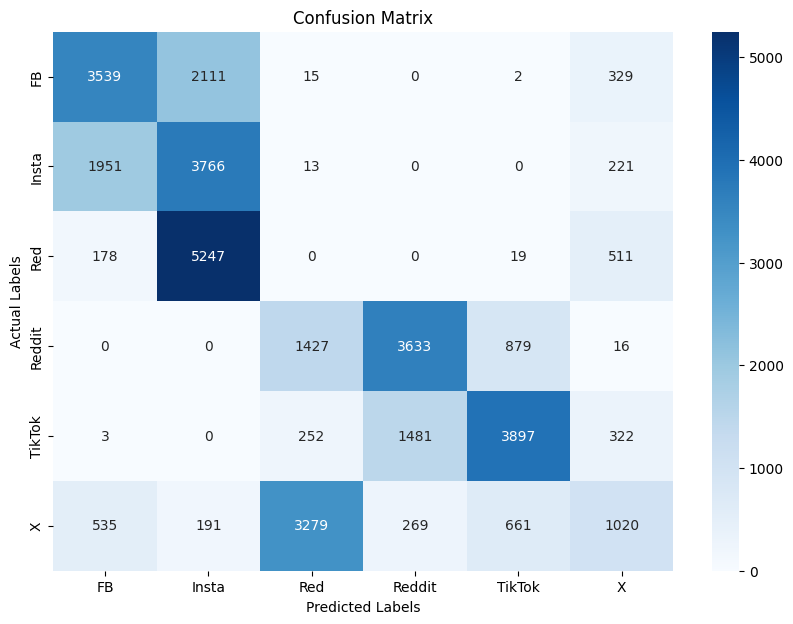

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Convert to DataFrame for better labeling in seaborn heatmap
cm_df = pd.DataFrame(cm,
                     index = [i for i in label_encoder.classes_], 
                     columns = [i for i in label_encoder.classes_])

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


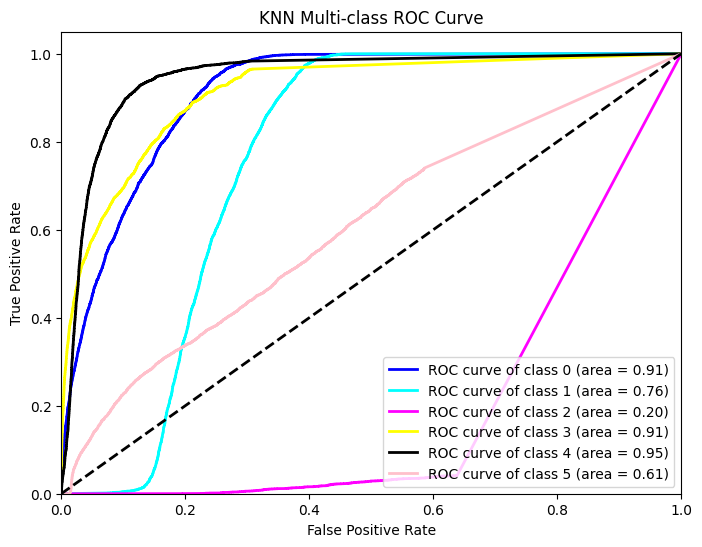

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_multiclass_roc(y_true, model, X, n_classes, title='Multiclass ROC Curve'):
    # Binarize the output labels for multi-class plotting
    y_bin = label_binarize(y_true, classes=range(n_classes))
    n_classes = y_bin.shape[1]

    # Check if the model can predict probabilities
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at these points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        plt.figure(figsize=(8, 6))
        colors = cycle(['blue', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightblue', 'lightgreen', 'grey', 'orange'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("This model does not support probability estimates.")

# Example usage with your KNN model
n_classes = len(np.unique(y_train_encoded))  # Adjust based on the actual number of classes
plot_multiclass_roc(y_test_encoded, knn_model, X_test, n_classes=n_classes, title='KNN Multi-class ROC Curve')


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5ea8f536-739f-4c50-806e-84490cb7d5e0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>